**expected behaviour:**
1. scan the terrain
2. locate panel
3. drive toward (close to the) panel

**algorithm:**
1. video acquisition
2. panel highlighting
    1. terrain remotion
    2. filtering
3. roi identification
    1. contours
    1. bounding box and center
4. motion
    1. motion direction
    2. motion performance
5. panel tracking
    1. roi features
    2. features matching
    3. moved roi estimation


In [12]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import glob
# in case of deprecation warning issued
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

###################################################################################################
###################################################################################################
# SOURCE IMAGE/VIDEO STREAM ACQUISITION
#_changed in a cycle in amin program, since easier than returning current frame too

# def videoGe(sourceVideo):
#     objectVideo = cv.VideoCapture(sourceVideo)
#     if objectVideo.isOpened():
#         returnCapture, frameCapture =objectVideo.read()
#         heightFrame,widthFrame,_=frameCapture.shape
#         return frameCapture,(heightFrame,widthFrame)
#     else: objectVideo.release(); return 0

###################################################################################################
###################################################################################################
# FOREGROUND/BACKGROUND SEPARATION
def panelFy(srcImg,sampleMet='library',samplePath='../../images/marsyard/samples/terrain/',bypassComp=0):
    

    # histogram param, for hs(v) space
    hBins = 180
    sBins = 255
    histSize = [hBins, sBins]
    hRanges = [1, 180]
    sRanges = [1, 256]
    Ranges = hRanges + sRanges
    Channels = [0, 1]

    # histogram(cdf) comparison method
    histCompLib = (
        ("Correlation", cv.HISTCMP_CORREL, 0.2),#or  0.4
        ("Chi-Squared", cv.HISTCMP_CHISQR, 10000000),
        ("Intersection", cv.HISTCMP_INTERSECT, 0.45),
        ("Hellinger", cv.HISTCMP_BHATTACHARYYA, 0),
        ("Kullback-Leibler",cv.HISTCMP_KL_DIV, 500))

    # choosen method and comparison threshold
    _,histCompMet, histCompThr =histCompLib[1]

    ############################
#     # samples folder
#     samplePath='../../images/marsyard/samples/terrain/'
#     # roi extraction methods   
#     sampleMetLib=('library',
#             'stream')
#     # selected roi extraction method
#     sampleMet=sampleMetLib[0]
    ##############################
    # mask's filter param and threshold value (mask is decimal)
    if sampleMet=='library':      
        sizeElMask=3
        tyElMask=cv.MORPH_RECT
        thrValMask=10#CORREL:10, CHISQR:0-20,

    elif 'stream':
        numElMask=4
        dimRowMask=img.shape[0]//numElMask
        dimColMask=img.shape[1]//numElMask

        sizeElMask=4
        tyElMask=cv.MORPH_RECT
        thrValMask=50    
    ################################
    # source prefiltering and color
    srcImgh=cv.cvtColor(srcImg,cv.COLOR_BGR2HSV)
    
    # source histogram
    srcImghhist = cv.calcHist([srcImgh], Channels, None, histSize, Ranges, accumulate=False)
    cv.normalize(srcImghhist, srcImghhist, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
    
    # array of good samples
    niceSamples=[]
    ##may be usefull for advanced parameter passing
    # foreground mask initialization
#     foreMask=np.zeros(srcImg.shape,np.uint8)##3channel mask
    foreMask=np.zeros((srcImg.shape[0],srcImg.shape[1]),np.uint8)##mono channel mask
    # picks roi from samples library
    if sampleMet=='library':
        for tempLibImg in glob.glob(samplePath+"*.jpg"):## manages only .jpg
            # roi acquisition
            tempLibImg=cv.cvtColor(cv.imread(tempLibImg),cv.COLOR_BGR2HSV)
            # roi hist
            roihhist= cv.calcHist([tempLibImg], Channels, None, histSize, Ranges, accumulate=False)
            cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
               # roi correlation test
            if cv.compareHist(srcImghhist, roihhist, histCompMet)>histCompThr or bypassComp:
                # usefull roi saved
                niceSamples.append(tempLibImg)
                # roi mask, mask smoothing and binarization, 3 channels conversion
                bpMask = cv.calcBackProject([srcImgh],Channels,roihhist,Ranges,1)
                cv.filter2D(bpMask,-1,cv.getStructuringElement(tyElMask,(sizeElMask,sizeElMask)),bpMask)
                _,thrChanMask = cv.threshold(bpMask,thrValMask,255,0)
                # foreground mask
#                 foreMask=cv.bitwise_or(foreMask,cv.merge((thrChanMask,thrChanMask,thrChanMask)))##3 channel
                foreMask=cv.bitwise_or(foreMask,thrChanMask)##mono channel mask
    # picks roi from target image itself
#     elif 'stream':

#_add color segmentation(name?, as colors reduction) to higligth different areas to choose
#         # target grid division
#         for jj in range(0,srcImg.shape[0],dimRowMask):
#             for ii in range(0,srcImg.shape[1],dimColMask):
#                 # roi acquisition
#                 tempLibImg=cv.cvtColor(srcImg[jj:jj+dimRowMask,ii:ii+dimColMask],cv.COLOR_BGR2HSV)
#                 # roi histogram
#                 roihhist= cv.calcHist([tempLibImg], Channels, None, histSize, Ranges, accumulate=False)
#                 cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
#                 # roi correlation test
#                 if cv.compareHist(srcImghhist, roihhist, histCompMet)>histCompThr:
#                     # usefull roi saved
#                     niceSamples.append(tempLibImg)
#                     # roi mask, mask smoothing and binarization, 3 channels conversion
#                     bpMask = cv.calcBackProject([srcImgh],Channels,roihhist,Ranges,1)
#                     cv.filter2D(bpMask,-1,cv.getStructuringElement(tyElMask,(sizeElMask,sizeElMask)),bpMask)
#                     _,thrChanMask = cv.threshold(bpMask,thrValMask,255,0)
#                     # inverted foreground mask
#                     foreMask=cv.bitwise_or(foreMask,cv.merge((thrChanMask,thrChanMask,thrChanMask)))

    # foreground mask
#     foreMask=cv.bitwise_not(foreMask)
    # masked source image
#     foreResImg = cv.bitwise_and(srcImg,foreMask)
    if not bypassComp: print('nice samples:',len(niceSamples))
#_add mask improvement:
#_1) opening for reduction of smaller blobs
#_2) comparison of histograms of different chuncks to highlight the most different ones
    return cv.bitwise_not(foreMask)#, foreResImg

###################################################################################################
###################################################################################################

# ROI HIGHLIGHTING
def roiFy(img2roi,groundRef=[],nocount=1,nohull=1,nomask=1,norect=0,nocentr=0):
# def roiFy(img2roi=[],img2hud=[],cont2hud=[],hull2hud=[],nocount=1,nohull=1,norect=0,nocentr=0):
## second parameter: image where hud drawn
#     def closeCnt(image2close):## NOT WORKING
#         kernel = np.ones((25,25),np.uint8)#cv.getStructuringElement(cv.MORPH_RECT,(10,10)) 
#         image2close=cv.morphologyEx(image2close,cv.MORPH_CLOSE,kernel)
#         image2close=cv.morphologyEx(image2close,cv.MORPH_RECT,kernel)
#         kernel =cv.getStructuringElement(cv.MORPH_RECT,(10,10))
#         image2close=cv.dilate(image2close,kernel,iterations=2)
#         kernel = np.ones((15,15),np.uint8)
#         image2close=cv.morphologyEx(image2close,cv.MORPH_OPEN,kernel)
#         return image2close
    # img2roi always where roi is drawn
    img2hud=img2roi.copy()
    # checks if img2roi is intended to be masked and applies correct masking operation
    if len(groundRef)>0:
        img2roi=cv.bitwise_and(img2roi,groundRef) if len(groundRef.shape)>2 else\
                    cv.bitwise_and(img2roi,img2roi,mask=groundRef)
    # prefiltering
    #foreground=bgForeImprov(foreground)
    
    # grayscaling and binarization
    cntsImRoi = cv.cvtColor(img2roi, cv.COLOR_BGR2GRAY)
    
    # thresholding ##IMPROV
    #imgtrack = cv.threshold(bpMask,10,255,0)#, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    cntsImRoi[cntsImRoi<10]=0
    cntsImRoi[cntsImRoi>=10]=255
    
    # contours
    cntsRoi = cv.findContours(cntsImRoi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cntsRoi = cntsRoi[0] if len(cntsRoi) == 2 else cntsRoi[1]#_susbtituible
    # closing contours (can be also image operations before extraction)
    # cntsImRoi=closeCnt(cntsImRoi)
    maxCntRoi=max(cntsRoi, key=len)
    #_maxCntRoi=max(cntsRoi, key=lambda x: cv.contourArea(x)) ##alternatively
    
    # hull(max contour) and hullmask(max)
    hullRoi=cv.convexHull(maxCntRoi)
    hullMask=cv.fillConvexPoly(np.zeros((img2roi.shape[0],img2roi.shape[1]),np.uint8),hullRoi,255)
    
    # masked foreground image
#     img2roi=cv.bitwise_and(img2roi,img2roi,mask=hullMask)
    if not nomask: img2hud=cv.bitwise_and(img2hud,img2hud,mask=hullMask)
    # RETURN ROI RECTANGLE AND ROI CENTER AND COSMETICHS
#     def roiHud(input2hud,cnt2hud):
    # draw max contour
    if not nocount:cv.drawContours(img2hud, maxCntRoi, -1,(25,205,255), 10)

    # draw convex hull
    if not nohull:cv.drawContours(img2hud, [hullRoi], -1, (255, 255, 0), 5)

    # rotated rect 
#   rRectRoi = cv.minAreaRect(maxCntRoi)
#   rBoxRoi = np.int0(cv.boxPoints(rRectRoi))
#   cv.drawContours(img2hud, [rBoxRoi], 0, (0,0,255), 8)

    # bounding rect and center
    xRHud,yRHud,widthRoi,heightRoi = cv.boundingRect(maxCntRoi)
    if not norect:cv.rectangle(img2hud, (xRHud,yRHud), (xRHud+widthRoi,yRHud+heightRoi), (255,0,255), 5)

    # rectangle center
    centerRoi=(xcRHud,ycRHud)=(xRHud+widthRoi//2, yRHud+heightRoi//2)
    if not nocentr:cv.circle(img2hud, centerRoi, 15, (0,255,0), 18)

    return img2hud,centerRoi,widthRoi,heightRoi,hullMask#,img2roi

###################################################################################################
###################################################################################################
# ROBOT MOTION SIMULATION
def moveRob():
    return 0

###################################################################################################
###################################################################################################
# PANEL TRACKING FUNCTION
def panelTra(roimage,roivertx,roiverty,roiwidth,roiheight,videobject,\
             trackmethod='histogram',doMeanShift=1,distancearray=[]):
    if trackmethod=='histogram':
    ## TRACKING BY HISTOGRAM BACKPROJECTION
        # PARAMETERS
        # Setup the termination criteria, either 10 iteration or move by atleast 1 pt
        term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
        # toggles use of only Hue channel    
        hChanOnly=1
        # histogram ## better define this as global variables
        hBins = 180;sBins = 256
        histSize = [hBins] if hChanOnly else [hBins,sBins]
        Ranges = hRanges = [0, 180]
        if not hChanOnly:sRanges = [0, 256]; Ranges+=sRanges
        Channels = [0] if hChanOnly else [0, 1]
        # frame size
        frameheight,framewidth,_=roimage.shape
        framecenx,frameceny=framewidth//2,frameheight//2
        # maximum roi area
    #     roivertx,roiverty=roicenx-roiwidth//2,roiceny-roiheight//2 ##or:
        roicenx,roiceny=roivertx+roiwidth//2,roiverty+roiheight//2

        # reduced roi area, concentric
        ##WHICH SHAPE? MASK?
        # small rectangular area
        smlroireduxfactor=3
        smlroiwidth,smlroiheigth=roiwidth//smlroireduxfactor,roiheight//smlroireduxfactor
        smlroivertx,smlroiverty=roicenx-smlroiwidth//2,roiceny-smlroiheigth//2


        # HISTOGRAM TRACKING
        roiregion=roimage[roiverty:roiverty+roiheight,roivertx:roivertx+roiwidth]
        roiregionh=cv.cvtColor(roiregion,cv.COLOR_BGR2HSV)
        roiwindow=(roivertx,roiverty,roiwidth,roiheight)
        smlroiregion=roimage[smlroiverty:smlroiverty+smlroiheigth,\
                             smlroivertx:smlroivertx+smlroiwidth]
        smlroiregionh=cv.cvtColor(smlroiregion,cv.COLOR_BGR2HSV)
        smlroiwindow=(smlroivertx,smlroiverty,smlroiwidth,smlroiheigth)

        # ROI histograms
        # as taken from masking result, in foreground coord
    #     roiMaskedh=cv.cvtColor(foreground[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2].copy(),cv.COLOR_BGR2HSV)

        roiLib=(roiregionh,smlroiregionh)#,roiMaskedh)
        roiChoo=1
        roi_select=roiLib[roiChoo]

        # mask for black pixels
        blackMask=roi_select[...,2] !=0
    #     blackMask=blackMask.astype(np.uint8)
        histMask=None  if roiChoo!=2 else blackMask.astype(np.uint8)

        histroi=cv.calcHist([roi_select],Channels,histMask,histSize,Ranges)
        cv.normalize(histroi,histroi,0,255,cv.NORM_MINMAX)

    ## efficient combination of roi and used channels
    ## only h,    small,natural   :low
    ## both h,s   big, masked     :early  

    # toggles use of meanshift or camshift (if 0)
        while(1):
            videoret, videoframe = videobject.read()

            if videoret == True:
                videoframeh = cv.cvtColor(videoframe, cv.COLOR_BGR2HSV)

                videodest = cv.calcBackProject([videoframeh],Channels,histroi,Ranges,1)

                if doMeanShift:
                    # apply meanshift to get the new location
                    videoret, roiwindow = cv.meanShift(videodest, roiwindow, term_crit)
                    # Draw it on image
                    xtr,ytr,wtr,htr = roiwindow
                    trackresult = cv.rectangle(videoframe, (xtr,ytr),(xtr+wtr,ytr+htr), (0,255,0),10)
                    trcenterx,trcentery=xtr+wtr//2,ytr+htr//2
                    cv.circle(trackresult,(trcenterx,trcentery),10,255,-1)
                    distancearray.append((trcenterx-framecenx,trcentery-frameceny))
                else:
                        # apply camshift to get the new location
                        videoret, roiwindow = cv.CamShift(videodest, roiwindow, term_crit)
                        # Draw it on image
                        trackpnts = np.int0(cv.boxPoints(videoret))
                        trackresult = cv.polylines(videoframe,[trackpnts],True, (0,255,0),10)
                        #_add roi center drawing
                        #_add distancearray value
                cv.imshow('tracking result',trackresult)
                k = cv.waitKey(30) & 0xff
                if k == 27:break
            else:break
        cv.destroyAllWindows()
        videobject.release()
        
    ##########################################################################################
    
    elif 'feature':
    ## TRACKING BY FEATURE MATCHING
        # PARAMETERS
        # sift initialization
        sift = cv.xfeatures2d.SIFT_create()
        # flann initialization
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        MIN_MATCH_COUNT = 6


        # greyscaling
        convGray=1
        roicenterx,roicentery=roivertx+roiwidth//2,roiverty+roiheight//2
        # query region for feature tracking, concentric with roi
        reduxFactor=8
        qheight,qwidth=roiheight//reduxFactor,roiwidth//reduxFactor
        qvertx,qverty=roicenterx-qwidth//2,roicentery-qheight//2## upperleftmost corner
        query_img=roimage[qverty:qverty+qheight,qvertx:qvertx+qwidth]
        # extraction of query keypoint and descriptors
        query_imgg=cv.cvtColor(query_img,cv.COLOR_BGR2GRAY) if convGray else query_img
        query_kp=sift.detect(query_imgg) 
        query_kp, query_desc=sift.compute(query_imgg,query_kp)

        while(1):
            videoret, videoframe = videobject.read()

            if videoret == True:
                # extraction of target keypoint and descriptors
                target_img=videoframe
                target_imgg=cv.cvtColor(target_img,cv.COLOR_BGR2GRAY) if convGray else target_img
                target_kp = sift.detect(target_imgg)
                target_kp,target_desc = sift.compute(target_imgg,target_kp)

                matches = flann.knnMatch(query_desc,target_desc,k=2)
                good_matches = []
                for m,n in matches:
                    if m.distance < 0.7*n.distance:
                        good_matches.append(m)

                if len(good_matches)>=MIN_MATCH_COUNT:
                    corSrc_pts = np.float32([ query_kp[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
                    corDst_pts = np.float32([ target_kp[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
                    matcHom, maskTrash = cv.findHomography(corSrc_pts, corDst_pts, cv.RANSAC, 5.0)
                    matchesMask = maskTrash.ravel().tolist()
                    matchPts = np.float32([ [0,0],[0,qheight-1],\
                                           [qwidth-1,qheight-1],[qwidth-1,0] ]).reshape(-1,1,2)
                    destPts = np.int32(cv.perspectiveTransform(matchPts,matcHom))

                    (destcenx,destceny)=destcen=((destPts[0]+destPts[2])//2).reshape(2,1,1)[0],\
                                                ((destPts[0]+destPts[2])//2).reshape(2,1,1)[1]
                    cv.rectangle(target_img,(destcenx-qwidth//2,destceny-qheight//2),\
                                (destcenx+qwidth//2,destceny+qheight//2),100,3)
                    ##alternatively:
                #     roiframe = cv.polylines(target_img,[destPts],True,255,3, cv.LINE_AA)

                    cv.circle(target_img,destcen,10,255,3)
                else:
                    print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
                    matchesMask = None

        #         plt.figure(figsize=(20,10));plt.imshow(target_img);plt.show();

                cv.imshow('tracking result',target_img)
                k = cv.waitKey(30) & 0xff
                if k == 27:
                    break
            else:
                break
        cv.destroyAllWindows()
    return
# def panelTra(roimage,roivertx,roiverty,roiwidth,roiheight,videobject,\
#              trackmethod='histogram',doMeanShift=1,distancearray=[]):
#     # PARAMETERS
#     # Setup the termination criteria, either 10 iteration or move by atleast 1 pt
#     term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )
#     # toggles use of only Hue channel    
#     hChanOnly=1
#     # histogram ## better define this as global variables
#     hBins = 180;sBins = 256
#     histSize = [hBins] if hChanOnly else [hBins,sBins]
#     Ranges = hRanges = [0, 180]
#     if not hChanOnly:sRanges = [0, 256]; Ranges+=sRanges
#     Channels = [0] if hChanOnly else [0, 1]
#     # frame size
#     frameheight,framewidth,_=roimage.shape
#     framecenx,frameceny=framewidth//2,frameheight//2
#     # maximum roi area
# #     roivertx,roiverty=roicenx-roiwidth//2,roiceny-roiheight//2 ##or:
#     roicenx,roiceny=roivertx+roiwidth//2,roiverty+roiheight//2
    
#     # reduced roi area, concentric
#     ##WHICH SHAPE? MASK?
#     # small rectangular area
#     smlroireduxfactor=3
#     smlroiwidth,smlroiheigth=roiwidth//smlroireduxfactor,roiheight//smlroireduxfactor
#     smlroivertx,smlroiverty=roicenx-smlroiwidth//2,roiceny-smlroiheigth//2
    
    
#     # HISTOGRAM TRACKING
#     roiregion=roimage[roiverty:roiverty+roiheight,roivertx:roivertx+roiwidth]
#     roiregionh=cv.cvtColor(roiregion,cv.COLOR_BGR2HSV)
#     roiwindow=(roivertx,roiverty,roiwidth,roiheight)
#     smlroiregion=roimage[smlroiverty:smlroiverty+smlroiheigth,\
#                          smlroivertx:smlroivertx+smlroiwidth]
#     smlroiregionh=cv.cvtColor(smlroiregion,cv.COLOR_BGR2HSV)
#     smlroiwindow=(smlroivertx,smlroiverty,smlroiwidth,smlroiheigth)
        
#     # ROI histograms
#     # as taken from masking result, in foreground coord
# #     roiMaskedh=cv.cvtColor(foreground[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2].copy(),cv.COLOR_BGR2HSV)

#     roiLib=(roiregionh,smlroiregionh)#,roiMaskedh)
#     roiChoo=1
#     roi_select=roiLib[roiChoo]
    
#     # mask for black pixels
#     blackMask=roi_select[...,2] !=0
# #     blackMask=blackMask.astype(np.uint8)
#     histMask=None  if roiChoo!=2 else blackMask.astype(np.uint8)

#     histroi=cv.calcHist([roi_select],Channels,histMask,histSize,Ranges)
#     cv.normalize(histroi,histroi,0,255,cv.NORM_MINMAX)

# ## efficient combination of roi and used channels
# ## only h,    small,natural   :low
# ## both h,s   big, masked     :early  

#     while(1):
#         videoret, videoframe = videobject.read()

#         if videoret == True:
#             videoframeh = cv.cvtColor(videoframe, cv.COLOR_BGR2HSV)

#             videodest = cv.calcBackProject([videoframeh],Channels,histroi,Ranges,1)

#             if doMeanShift:
#                 # apply meanshift to get the new location
#                 videoret, roiwindow = cv.meanShift(videodest, roiwindow, term_crit)
#                 # Draw it on image
#                 xtr,ytr,wtr,htr = roiwindow
#                 trackresult = cv.rectangle(videoframe, (xtr,ytr),(xtr+wtr,ytr+htr), (0,255,0),10)
#                 trcenterx,trcentery=xtr+wtr//2,ytr+htr//2
#                 cv.circle(trackresult,(trcenterx,trcentery),10,255,-1)
#                 distancearray.append((trcenterx-framecenx,trcentery-frameceny))
#             else:
#                     # apply camshift to get the new location
#                     videoret, roiwindow = cv.CamShift(videodest, roiwindow, term_crit)
#                     # Draw it on image
#                     trackpnts = np.int0(cv.boxPoints(videoret))
#                     trackresult = cv.polylines(videoframe,[trackpnts],True, (0,255,0),10)
#                     #_add roi center drawing
#                     #_add distancearray value
#             cv.imshow('tracking result',trackresult)
#             k = cv.waitKey(30) & 0xff
#             if k == 27:break
#         else:break
#     cv.destroyAllWindows()
#     return

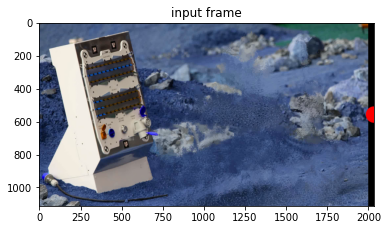

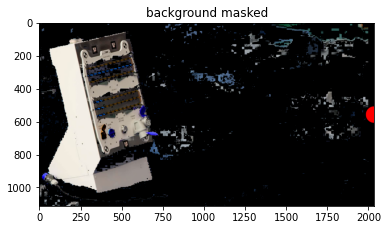

(1112, 4070, 3) (1112, 4070)


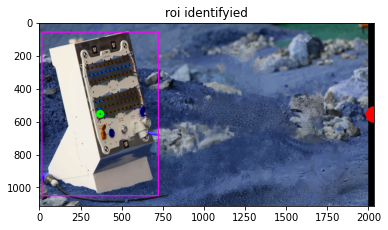

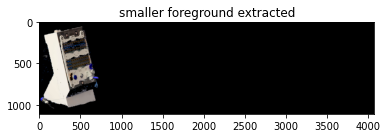

In [8]:
# add POV center
centMark=1
# video source
videoSrc='../../images/video/task/task_ext.avi'
# image source
imageSrc='../../images/marsyard/taskfinal.jpg'


# ROI ####################
#frameVid,frameSiz=videoGe(videoSrc)
#if centMark: cv.circle(frameVid,(widthFrame//2,heightFrame//2),50,(255),-1)
#plt.title('input frame');plt.imshow(frameVid);plt.show()
    
objectVideo = cv.VideoCapture(videoSrc)
if objectVideo.isOpened():
    returnCapture, frameVid =objectVideo.read()
# else:release; exit(1)

heightFrame,widthFrame,_=frameVid.shape

if centMark: frameDis=cv.circle(frameVid.copy(),(widthFrame//2,heightFrame//2),50,(255),-1)
plt.title('input frame');plt.imshow(frameDis[:,:widthFrame//2]);plt.show()

# remotion of background
panelMask=panelFy(frameVid)
# maskedImg=cv.bitwise_and(frameVid,panelMask)##3channel mask
maskedImg=cv.bitwise_and(frameVid,frameVid,mask=panelMask)##mono channel mask
if centMark: maskedDis=cv.circle(maskedImg.copy(),(widthFrame//2,heightFrame//2),50,(255),-1)
plt.title('background masked');plt.imshow(maskedDis[:,:widthFrame//2]);plt.show()

# identification of panel  
print(frameVid.shape, panelMask.shape)
hudImg,rco,wr,hr,roiMask=roiFy(frameVid,groundRef=panelMask)
(rcox,rcoy)=rco
roix,roiy=rcox-wr//2,rcoy-hr//2
if centMark: hudDis=cv.circle(hudImg.copy(),(widthFrame//2,heightFrame//2),50,(255),-1)
plt.title('roi identifyied');plt.imshow(hudDis[:,:widthFrame//2]);plt.show()
plt.title('smaller foreground extracted');
plt.imshow(cv.bitwise_and(maskedImg,maskedImg,mask=roiMask));plt.show()

# TRACKING ###################################
methodTrkLib=('histogram','feature','subtraction')
methodTrk=methodTrkLib[0]

if methodTrk=='histogram' or methodTrk=='feature':
# using histogram/feature tracking
    panelTra(frameVid,roix,roiy,wr,hr,videobject=objectVideo,trackmethod=methodTrk,distancearray=[])
else:
# re-performing background remotion and panel identification
    while(1):

        if objectVideo.isOpened():
            returnCaptureTrk, frameVidTrk =objectVideo.read()
        # else:release; exit(1)

        # remotion of background
        panelMaskTrk=panelFy(frameVidTrk)
        # maskedImgTrk=cv.bitwise_and(frameVidTrk,panelMaskTrk)##3channel mask
        maskedImgTrk=cv.bitwise_and(frameVidTrk,frameVidTrk,mask=panelMaskTrk)##mono channel mask
    #     if centMark: maskedDisTrk=cv.circle(maskedImgTrk.copy(),(widthFrame//2,heightFrame//2),50,(255),-1)
    #     plt.title('background masked');plt.imshow(maskedDisTrk[:,:widthFrame//2]);plt.show()

        # identification of panel  
        hudImgTrk,rcoTrk,wrTrk,hrTrk,roiMaskTrk=roiFy(frameVidTrk,groundRef=panelMaskTrk)
        (rcoxTrk,rcoyTrk)=rcoTrk
        roixTrk,roiyTrk=rcoxTrk-wrTrk//2,rcoyTrk-hrTrk//2
        if centMark: hudDisTrk=cv.circle(hudImgTrk.copy(),(widthFrame//2,heightFrame//2),50,(255),-1)
        #     plt.title('smaller foreground extracted');
        #     plt.imshow(cv.bitwise_and(maskedImgTrk,maskedImgTrk,mask=roiMaskTrk));plt.show()
        cv.imshow('roi identifyied',hudDisTrk[:,:widthFrame//2])
        k = cv.waitKey(30) & 0xff
        if k == 27: break
    cv.destroyAllWindows()

objectVideo.release()

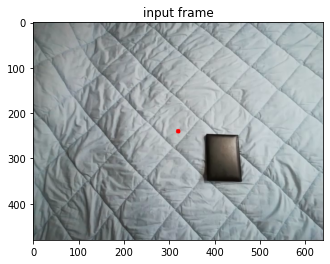

nice samples: 8


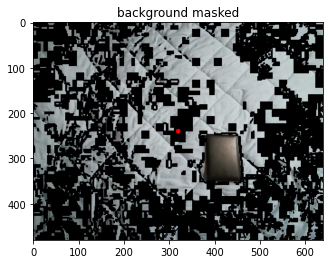

(480, 640, 3) (480, 640)


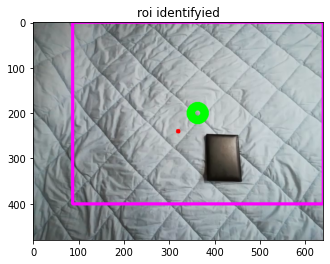

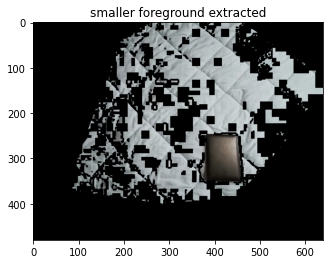

In [11]:
# add POV center
centMark=1
# video source
videoSrc='../../images/video/bed/bed4.mp4'
# image source
imageSrc='../../images/bed/bed.jpg'


# ROI ####################
#frameVid,frameSiz=videoGe(videoSrc)
#if centMark: cv.circle(frameVid,(widthFrame//2,heightFrame//2),50,(255),-1)
#plt.title('input frame');plt.imshow(frameVid);plt.show()
    
objectVideo = cv.VideoCapture(videoSrc)
if objectVideo.isOpened():
    returnCapture, frameVid =objectVideo.read()
# else:release; exit(1)

heightFrame,widthFrame,_=frameVid.shape

if centMark: frameDis=cv.circle(frameVid.copy(),(widthFrame//2,heightFrame//2),5,(255),-1)
plt.title('input frame');plt.imshow(frameDis);plt.show()

# remotion of background
panelMask=panelFy(frameVid,samplePath='../../images/bed/samples/vid2/',bypassComp=1)
# maskedImg=cv.bitwise_and(frameVid,panelMask)##3channel mask
maskedImg=cv.bitwise_and(frameVid,frameVid,mask=panelMask)##mono channel mask
if centMark: maskedDis=cv.circle(maskedImg.copy(),(widthFrame//2,heightFrame//2),5,(255),-1)
plt.title('background masked');plt.imshow(maskedDis);plt.show()

# identification of panel  
print(frameVid.shape, panelMask.shape)
hudImg,rco,wr,hr,roiMask=roiFy(frameVid,groundRef=panelMask)
(rcox,rcoy)=rco
roix,roiy=rcox-wr//2,rcoy-hr//2
if centMark: hudDis=cv.circle(hudImg.copy(),(widthFrame//2,heightFrame//2),5,(255),-1)
plt.title('roi identifyied');plt.imshow(hudDis);plt.show()
plt.title('smaller foreground extracted');
plt.imshow(cv.bitwise_and(maskedImg,maskedImg,mask=roiMask));plt.show()

# TRACKING ###################################
methodTrkLib=('histogram','feature','subtraction')
methodTrk=methodTrkLib[0]

if methodTrk=='histogram' or methodTrk=='feature':
# using histogram/feature tracking
    panelTra(frameVid,roix,roiy,wr,hr,videobject=objectVideo,trackmethod=methodTrk,distancearray=[])
else:
# re-performing background remotion and panel identification
    while(1):

        if objectVideo.isOpened():
            returnCaptureTrk, frameVidTrk =objectVideo.read()
        # else:release; exit(1)

        # remotion of background
        panelMaskTrk=panelFy(frameVidTrk)
        # maskedImgTrk=cv.bitwise_and(frameVidTrk,panelMaskTrk)##3channel mask
        maskedImgTrk=cv.bitwise_and(frameVidTrk,frameVidTrk,mask=panelMaskTrk)##mono channel mask
    #     if centMark: maskedDisTrk=cv.circle(maskedImgTrk.copy(),(widthFrame//2,heightFrame//2),50,(255),-1)
    #     plt.title('background masked');plt.imshow(maskedDisTrk[:,:widthFrame//2]);plt.show()

        # identification of panel  
        hudImgTrk,rcoTrk,wrTrk,hrTrk,roiMaskTrk=roiFy(frameVidTrk,groundRef=panelMaskTrk)
        (rcoxTrk,rcoyTrk)=rcoTrk
        roixTrk,roiyTrk=rcoxTrk-wrTrk//2,rcoyTrk-hrTrk//2
        if centMark: hudDisTrk=cv.circle(hudImgTrk.copy(),(widthFrame//2,heightFrame//2),5,(255),-1)
        #     plt.title('smaller foreground extracted');
        #     plt.imshow(cv.bitwise_and(maskedImgTrk,maskedImgTrk,mask=roiMaskTrk));plt.show()
        cv.imshow('roi identifyied',hudDisTrk)
        k = cv.waitKey(30) & 0xff
        if k == 27: break
    cv.destroyAllWindows()

objectVideo.release()

In [24]:
# extract first frame and save

# videoSrc='../../images/video/bed/bed3.mp4'
    
# objectVideo = cv.VideoCapture(videoSrc)
# if objectVideo.isOpened():
#     returnCapture, frameVid =objectVideo.read()
#     cv.imwrite('../../images/bed/bedvid3.jpg',frameVid)